# This notebook will dedicate to create an ML model that predicts price per sqft based on location data

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
import requests
import time
import random
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

##Supervised Learning
from sklearn.model_selection import cross_validate, KFold
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline
from datetime import datetime
import seaborn as sns

from scipy import stats

##Deep learning session
import tensorflow as tf
from keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(123)
tf.random.set_seed(123)

In [2]:
###Read in the location data with longitude, latitude, and zipcodes
###I will pick only longitude and latitude first and see if the model performs well
###I will use February 2023 as a test
df_location = pd.read_csv('Location_data/February_2023_houses_location.csv')
df_location

,zpid,latitude,longitude,zipcode_75001,zipcode_75002,zipcode_75006,zipcode_75007,zipcode_75009,zipcode_75010,zipcode_75013,...,zipcode_76462,zipcode_76485,zipcode_76486,zipcode_76487,zipcode_76651,zipcode_76670,zipcode_78681,zipcode_78753,zipcode_Other,pricesqft
0,7.894782e+07,33.361850,-97.696070,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,91.148649
1,2.399566e+08,33.164368,-97.439285,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,108.024691
2,7.893851e+07,33.076668,-97.565500,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,165.413534
3,7.894306e+07,33.292140,-97.807000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,159.680451
4,2.526456e+08,33.009575,-97.499040,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,206.582633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11199,2.059999e+09,32.365173,-96.935650,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1390.625000
11200,3.312331e+08,32.348778,-96.840440,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,264.900662
11201,2.066871e+09,32.539078,-96.842514,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,209.279070
11202,9.889846e+07,32.543800,-97.011894,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,221.691678


### Preparing the data for KNN (or even ANN)

In [3]:
###I would train the model to predict log(pricesqft)
df_model = df_location[['latitude', 'longitude', 'pricesqft']]
df_model

,latitude,longitude,pricesqft
0,33.361850,-97.696070,91.148649
1,33.164368,-97.439285,108.024691
2,33.076668,-97.565500,165.413534
3,33.292140,-97.807000,159.680451
4,33.009575,-97.499040,206.582633
...,...,...,...
11199,32.365173,-96.935650,1390.625000
11200,32.348778,-96.840440,264.900662
11201,32.539078,-96.842514,209.279070
11202,32.543800,-97.011894,221.691678


In [4]:
y_original = df_model['pricesqft'].to_numpy().reshape(-1, 1)
y_original

array([[ 91.14864865],
       [108.02469136],
       [165.41353383],
       ...,
       [209.27906977],
       [221.69167804],
       [659.75073314]])

In [5]:
y_target = np.log(df_model['pricesqft']).to_numpy().reshape(-1, 1)
y_target

array([[4.51249168],
       [4.68235982],
       [5.1084486 ],
       ...,
       [5.34366862],
       [5.40128758],
       [6.49186209]])

<AxesSubplot: >

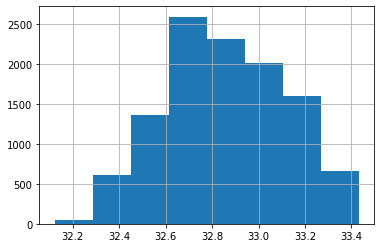

In [6]:
df_model['latitude'].hist(bins = 8)

<AxesSubplot: >

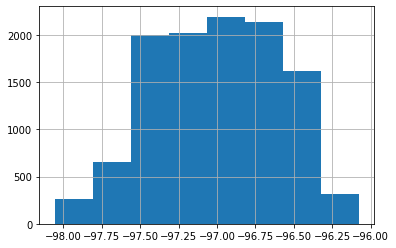

In [7]:
df_model['longitude'].hist(bins = 8)

In [8]:
##I will standardize the latitude and longitude and see how the model performs

##This function only focuses on standardize and normalize the dataset
##Splits: the number of folds I want to use
##scaler: the scaler that I will use to scale my data, mostly Sklearn scaler
def prep_data1(splits, scaler, df_model):
    data = df_model.to_numpy()
    cv = KFold(n_splits = splits, shuffle = True, random_state = 0)
    cv.split(data)

    train_set_dict = dict()
    train_target_dict = dict()
    scaled_train_set = dict()
    scaled_train_target = dict()

    test_set_dict = dict()
    test_target_dict = dict()
    scaled_test_set = dict()
    scaled_test_target = dict()

    ###Store K folds data into dictionary
    for i, (train_index, test_index) in enumerate(cv.split(data)):
        train_set = df_model.iloc[train_index].iloc[:, :-1]
        train_target = df_model.iloc[train_index].iloc[:, -1]
        train_set_dict['Fold ' + str(i)] = train_set.copy()
        train_target_dict['Fold ' + str(i)] = train_target.copy()

        test_set = df_model.iloc[test_index].iloc[:, :-1]
        test_target = df_model.iloc[test_index].iloc[:, -1]
        test_set_dict['Fold ' + str(i)] = test_set.copy()
        test_target_dict['Fold ' + str(i)] = test_target.copy()

        ###Standardize the latitude and longitude, log pricesqft
        train_latitude = train_set['latitude'].to_numpy().reshape(-1, 1)
        train_longitude = train_set['longitude'].to_numpy().reshape(-1, 1)

        test_latitude = test_set['latitude'].to_numpy().reshape(-1, 1)
        test_longitude = test_set['longitude'].to_numpy().reshape(-1, 1)

        scaler_latitude = scaler
        train_latitude_transformed = scaler_latitude.fit_transform(train_latitude)
        test_latitude_transformed = scaler_latitude.transform(test_latitude)
        train_set['latitude'] = train_latitude_transformed
        test_set['latitude'] = test_latitude_transformed

        scaler_longitude = scaler
        train_longitude_transformed = scaler_longitude.fit_transform(train_longitude)
        test_longitude_transformed = scaler_longitude.transform(test_longitude)
        train_set['longitude'] = train_longitude_transformed
        test_set['longitude'] = test_longitude_transformed

        scaled_train_set['Fold ' + str(i)] = train_set.to_numpy()
        scaled_train_target['Fold ' + str(i)] = np.log(train_target_dict['Fold ' + str(i)]).to_numpy().reshape(-1, 1)
        scaled_test_set['Fold ' + str(i)] = test_set.to_numpy()
        scaled_test_target['Fold ' + str(i)] = np.log(test_target_dict['Fold ' + str(i)]).to_numpy().reshape(-1, 1)
        
    return (train_set_dict, train_target_dict, scaled_train_set, scaled_train_target,
            test_set_dict, test_target_dict, scaled_test_set, scaled_test_target)

In [9]:
splits = 5
scaler1 = StandardScaler()
all_dicts = prep_data1(splits, scaler1, df_model)
train_set_dict1 = all_dicts[0]
train_target_dict1 = all_dicts[1]
scaled_train_set1 = all_dicts[2]
scaled_train_target1 = all_dicts[3]

test_set_dict1 = all_dicts[4]
test_target_dict1 = all_dicts[5]
scaled_test_set1 = all_dicts[6]
scaled_test_target1 = all_dicts[7]

In [10]:
scaled_test_target1['Fold 0']

array([[5.25013713],
       [5.23377885],
       [5.2913622 ],
       ...,
       [5.71560122],
       [5.90331801],
       [6.49186209]])

#### Build a KNN model

In [11]:
KNN_r = KNeighborsRegressor(n_neighbors = 55, weights = 'distance')
train_set = scaled_train_set1['Fold 1']
train_target = scaled_train_target1['Fold 1']
test_set = scaled_test_set1['Fold 1']
test_target = scaled_test_target1['Fold 1']
KNN_r.fit(train_set, train_target)

KNeighborsRegressor(n_neighbors=55, weights='distance')

In [12]:
np.exp(KNN_r.predict(test_set))

array([[212.75795563],
       [204.59397668],
       [198.3332592 ],
       ...,
       [176.53554971],
       [204.46875155],
       [171.589875  ]])

In [13]:
KNN_r.score(test_set, test_target)

0.3623322879073191

In [14]:
test_yFold1_observed = test_target_dict1['Fold 1'].to_numpy().reshape(-1, 1)
test_yFold1_predicted = np.exp(KNN_r.predict(test_set))
r2Fold1 = r2_score(test_yFold1_observed, test_yFold1_predicted)

n = len(test_yFold1_observed)
p = train_set.shape[1]
adjusted_r2Fold1 = 1 - ((1 - r2Fold1) * (n - 1) / (n - p - 1))

print("R2 score:", np.round(r2Fold1, 4))
print("Adjusted R2 score:", np.round(adjusted_r2Fold1, 4))

R2 score: 0.3182
Adjusted R2 score: 0.3176


In [18]:
###Let's calulcate R2 and adjusted R2 for all folds (Cross-validation technique)
R2_list = list()
adjusted_R2_list = list()

for i in range(5):
    KNN_r = KNeighborsRegressor(n_neighbors = 55, weights = 'distance')
    train_set = scaled_train_set1['Fold ' + str(i)]
    train_target = scaled_train_target1['Fold ' + str(i)]
    test_set = scaled_test_set1['Fold ' + str(i)]
    test_target = scaled_test_target1['Fold ' + str(i)]
    KNN_r.fit(train_set, train_target)
    
    test_observed = test_target_dict1['Fold ' + str(i)].to_numpy().reshape(-1, 1)
    test_predicted = np.exp(KNN_r.predict(test_set))
    r2 = r2_score(test_observed, test_predicted)
    n = test_observed.shape[0]
    p = train_set.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    R2_list.append(r2)
    adjusted_R2_list.append(adjusted_r2)
    
    print("Fold " + str(i + 1) + " Test R2 score:", np.round(r2, 4))
    print("Fold " + str(i + 1) + " Test Adjusted R2 score:", np.round(adjusted_r2, 4))
    print()

print("The average Test R2 : ", np.round(sum(R2_list)/len(R2_list), 4))
print("The average Test adjusted R2: ", np.round(sum(adjusted_R2_list)/len(adjusted_R2_list), 4))
###Overall the R2 score is around 0.2724, however can we achieve a better result with ANN?
###What if we add features as zipcode to our model?
##The model can only handle average values of price per square feet
##Look at distribution of prices per square foot in a zipcode

Fold 1 Test R2 score: 0.2318
Fold 1 Test Adjusted R2 score: 0.2311

Fold 2 Test R2 score: 0.3182
Fold 2 Test Adjusted R2 score: 0.3176

Fold 3 Test R2 score: 0.2116
Fold 3 Test Adjusted R2 score: 0.2109

Fold 4 Test R2 score: 0.3373
Fold 4 Test Adjusted R2 score: 0.3367

Fold 5 Test R2 score: 0.2631
Fold 5 Test Adjusted R2 score: 0.2625

The average Test R2 :  0.2724
The average Test adjusted R2:  0.2718


##### Using MinMaxScaler instead

In [19]:
splits = 5
scaler2 = MinMaxScaler()
all_dicts = prep_data1(splits, scaler2, df_model)
train_set_dict2 = all_dicts[0]
train_target_dict2 = all_dicts[1]
scaled_train_set2 = all_dicts[2]
scaled_train_target2 = all_dicts[3]

test_set_dict2 = all_dicts[4]
test_target_dict2 = all_dicts[5]
scaled_test_set2 = all_dicts[6]
scaled_test_target2 = all_dicts[7]

In [21]:
R2_list = list()
adjusted_R2_list = list()

for i in range(5):
    KNN_r = KNeighborsRegressor(n_neighbors = 55, weights = 'distance')
    train_set = scaled_train_set2['Fold ' + str(i)]
    train_target = scaled_train_target2['Fold ' + str(i)]
    test_set = scaled_test_set2['Fold ' + str(i)]
    test_target = scaled_test_target2['Fold ' + str(i)]
    KNN_r.fit(train_set, train_target)
    
    test_observed = test_target_dict2['Fold ' + str(i)].to_numpy().reshape(-1, 1)
    test_predicted = np.exp(KNN_r.predict(test_set))
    r2 = r2_score(test_observed, test_predicted)
    n = test_observed.shape[0]
    p = train_set.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    R2_list.append(r2)
    adjusted_R2_list.append(adjusted_r2)
    
    print("Fold " + str(i + 1) + " Test R2 score:", np.round(r2, 4))
    print("Fold " + str(i + 1) + " Test Adjusted R2 score:", np.round(adjusted_r2, 4))
    print()

print("The average Test R2 : ", np.round(sum(R2_list)/len(R2_list), 4))
print("The average Test adjusted R2: ", np.round(sum(adjusted_R2_list)/len(adjusted_R2_list), 4))

###So using a min max scaler, 
###Overall the R2 score is around 0.2724, however can we achieve a better result with ANN?
###What if we add features as zipcode to our model?

Fold 1 Test R2 score: 0.2316
Fold 1 Test Adjusted R2 score: 0.2309

Fold 2 Test R2 score: 0.3181
Fold 2 Test Adjusted R2 score: 0.3175

Fold 3 Test R2 score: 0.2113
Fold 3 Test Adjusted R2 score: 0.2105

Fold 4 Test R2 score: 0.3375
Fold 4 Test Adjusted R2 score: 0.3369

Fold 5 Test R2 score: 0.2631
Fold 5 Test Adjusted R2 score: 0.2625

The average Test R2 :  0.2723
The average Test adjusted R2:  0.2717


###### Try new features with February data

In [23]:
df_location2 = pd.read_csv('Location_data3/February_2023/February_2023_houses_location.csv')
df_location2

,zpid,latitude,longitude,county_lat,county_long,SD_lat,SD_long,zipcode_lat,zipcode_long,pricesqft
0,7.894782e+07,33.361850,-97.696070,33.219095,-97.653997,33.379846,-97.701165,33.374041,-97.667809,91.148649
1,2.399566e+08,33.164368,-97.439285,33.219095,-97.653997,33.237630,-97.539224,33.276319,-97.514178,108.024691
2,7.893851e+07,33.076668,-97.565500,33.219095,-97.653997,33.072593,-97.579633,33.041952,-97.597065,165.413534
3,7.894306e+07,33.292140,-97.807000,33.219095,-97.653997,33.326269,-97.829165,33.302787,-97.868426,159.680451
4,2.526456e+08,33.009575,-97.499040,33.219095,-97.653997,33.033006,-97.354880,33.011335,-97.474362,206.582633
...,...,...,...,...,...,...,...,...,...,...
11199,2.059999e+09,32.365173,-96.935650,32.346878,-96.796940,32.356339,-96.863493,32.360829,-96.915523,1390.625000
11200,3.312331e+08,32.348778,-96.840440,32.346878,-96.796940,32.356339,-96.863493,32.371654,-96.803030,264.900662
11201,2.066871e+09,32.539078,-96.842514,32.346878,-96.796940,32.515389,-96.811019,32.524259,-96.809069,209.279070
11202,9.889846e+07,32.543800,-97.011894,32.346878,-96.796940,32.472297,-97.000465,32.584814,-96.972312,221.691678


In [24]:
df_model2 = df_location2.copy()[['latitude', 'longitude', 'county_lat', 'county_long', 
                                 'SD_lat', 'SD_long', 'zipcode_lat', 'zipcode_long', 'pricesqft']]
df_model2

,latitude,longitude,county_lat,county_long,SD_lat,SD_long,zipcode_lat,zipcode_long,pricesqft
0,33.361850,-97.696070,33.219095,-97.653997,33.379846,-97.701165,33.374041,-97.667809,91.148649
1,33.164368,-97.439285,33.219095,-97.653997,33.237630,-97.539224,33.276319,-97.514178,108.024691
2,33.076668,-97.565500,33.219095,-97.653997,33.072593,-97.579633,33.041952,-97.597065,165.413534
3,33.292140,-97.807000,33.219095,-97.653997,33.326269,-97.829165,33.302787,-97.868426,159.680451
4,33.009575,-97.499040,33.219095,-97.653997,33.033006,-97.354880,33.011335,-97.474362,206.582633
...,...,...,...,...,...,...,...,...,...
11199,32.365173,-96.935650,32.346878,-96.796940,32.356339,-96.863493,32.360829,-96.915523,1390.625000
11200,32.348778,-96.840440,32.346878,-96.796940,32.356339,-96.863493,32.371654,-96.803030,264.900662
11201,32.539078,-96.842514,32.346878,-96.796940,32.515389,-96.811019,32.524259,-96.809069,209.279070
11202,32.543800,-97.011894,32.346878,-96.796940,32.472297,-97.000465,32.584814,-96.972312,221.691678


In [25]:
def prep_data(splits, scaler, df_model):
    data = df_model.to_numpy()
    cv = KFold(n_splits = splits, shuffle = True, random_state = 0)
    cv.split(data)

    train_set_dict = dict()
    train_target_dict = dict()
    scaled_train_set = dict()
    scaled_train_target = dict()

    test_set_dict = dict()
    test_target_dict = dict()
    scaled_test_set = dict()
    scaled_test_target = dict()

    ###Store K folds data into dictionary
    for i, (train_index, test_index) in enumerate(cv.split(data)):
        train_set = df_model.iloc[train_index].iloc[:, :-1]
        train_target = df_model.iloc[train_index].iloc[:, -1]
        train_set_dict['Fold ' + str(i)] = train_set.copy()
        train_target_dict['Fold ' + str(i)] = train_target.copy()

        test_set = df_model.iloc[test_index].iloc[:, :-1]
        test_target = df_model.iloc[test_index].iloc[:, -1]
        test_set_dict['Fold ' + str(i)] = test_set.copy()
        test_target_dict['Fold ' + str(i)] = test_target.copy()
        
        the_scaler = scaler
        scaled_train_set['Fold ' + str(i)] = the_scaler.fit_transform(train_set)
        scaled_train_target['Fold ' + str(i)] = np.log(train_target_dict['Fold ' + str(i)]).to_numpy().reshape(-1, 1)
        scaled_test_set['Fold ' + str(i)] = the_scaler.transform(test_set)
        scaled_test_target['Fold ' + str(i)] = np.log(test_target_dict['Fold ' + str(i)]).to_numpy().reshape(-1, 1)
        
    return (train_set_dict, train_target_dict, scaled_train_set, scaled_train_target,
            test_set_dict, test_target_dict, scaled_test_set, scaled_test_target)

In [26]:
splits = 5
scaler3 = MinMaxScaler()
all_dicts3 = prep_data(splits, scaler3, df_model2)
train_set3 = all_dicts3[0]
train_target3 = all_dicts3[1]
scaled_train_set3 = all_dicts3[2]
scaled_train_target3 = all_dicts3[3]

test_set3 = all_dicts3[4]
test_target3 = all_dicts3[5]
scaled_test_set3 = all_dicts3[6]
scaled_test_target3 = all_dicts3[7]

In [27]:
test_target3['Fold 0']

9        190.592402
14       187.500000
16       198.613793
18       234.618540
23       166.235669
            ...    
11170    289.190166
11179    200.800703
11185    303.566658
11189    366.250678
11203    659.750733
Name: pricesqft, Length: 2241, dtype: float64

In [28]:
R2_list = list()
adjusted_R2_list = list()

for i in range(5):
    KNN_r = KNeighborsRegressor(n_neighbors = 30, weights = 'distance')
    train_set = train_set3['Fold ' + str(i)]
    train_target = train_target3['Fold ' + str(i)].to_numpy()
    test_set = test_set3['Fold ' + str(i)]
    test_target = test_target3['Fold ' + str(i)].to_numpy()
    KNN_r.fit(train_set, train_target)
    
    test_observed = test_target3['Fold ' + str(i)].to_numpy().reshape(-1, 1)
    test_predicted = KNN_r.predict(test_set)
    r2 = r2_score(test_observed, test_predicted)
    n = test_observed.shape[0]
    p = train_set.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    R2_list.append(r2)
    adjusted_R2_list.append(adjusted_r2)
    
    print("Fold " + str(i + 1) + " Test R2 score:", np.round(r2, 4))
    print("Fold " + str(i + 1) + " Test Adjusted R2 score:", np.round(adjusted_r2, 4))
    print()

print("The average Test R2 : ", np.round(sum(R2_list)/len(R2_list), 4))
print("The average Test adjusted R2: ", np.round(sum(adjusted_R2_list)/len(adjusted_R2_list), 4))

##R2 is 28.1% for the overall targets
##Need to separate R2 into different groups of price.
##range_R2 = [(0,200), (200,400), (400,600), (600,'more')]

Fold 1 Test R2 score: 0.2347
Fold 1 Test Adjusted R2 score: 0.2319

Fold 2 Test R2 score: 0.3036
Fold 2 Test Adjusted R2 score: 0.3011

Fold 3 Test R2 score: 0.2258
Fold 3 Test Adjusted R2 score: 0.223

Fold 4 Test R2 score: 0.3573
Fold 4 Test Adjusted R2 score: 0.355

Fold 5 Test R2 score: 0.2835
Fold 5 Test Adjusted R2 score: 0.2809

The average Test R2 :  0.281
The average Test adjusted R2:  0.2784


### Build a ANN model

In [20]:
def ann_generator(input_shape):
    T = input_shape
    i = Input(shape = [T,])
    x = Dense(30)(i)
    x = Activation('relu')(x)
    x = Dense(30)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(20)(x)
    x = Activation('relu')(x)
    x = Dropout(0.10)(x)
    output = Dense(1)(x)
    model = Model(inputs = i, outputs = output)
    
    return model

#### Let's test this on standardized data

In [21]:
##Let's try this on Fold 1 and see the result
input_shape = 2
model1 = ann_generator(input_shape)
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 30)                90        
                                                                 
 activation (Activation)     (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 activation_1 (Activation)   (None, 30)                0         
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                620   

In [22]:
model1.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse'])
check_point = ModelCheckpoint('Location_ANN_2vars/model1_adam_ann.h5', monitor = 'val_mse', save_best_only = True)

Xtrain = scaled_train_set1['Fold 1']
ytrain = scaled_train_target1['Fold 1']
Xval = scaled_test_set1['Fold 1']
yval = scaled_test_target1['Fold 1']

result1 = model1.fit(Xtrain, ytrain, epochs = 30, validation_data = (Xval, yval), 
                     batch_size = 64, callbacks = [check_point])

Epoch 1/30
141/141 [==============================] - 2s 6ms/step - loss: 10.0145 - mse: 10.0145 - val_loss: 1.4067 - val_mse: 1.4067
Epoch 2/30
141/141 [==============================] - 1s 5ms/step - loss: 1.6691 - mse: 1.6691 - val_loss: 0.4880 - val_mse: 0.4880
Epoch 3/30
141/141 [==============================] - 1s 5ms/step - loss: 1.0059 - mse: 1.0059 - val_loss: 0.1678 - val_mse: 0.1678
Epoch 4/30
141/141 [==============================] - 1s 5ms/step - loss: 0.7487 - mse: 0.7487 - val_loss: 0.0858 - val_mse: 0.0858
Epoch 5/30
141/141 [==============================] - 1s 5ms/step - loss: 0.6505 - mse: 0.6505 - val_loss: 0.0744 - val_mse: 0.0744
Epoch 6/30
141/141 [==============================] - 1s 5ms/step - loss: 0.6035 - mse: 0.6035 - val_loss: 0.0740 - val_mse: 0.0740
Epoch 7/30
141/141 [==============================] - 1s 5ms/step - loss: 0.5791 - mse: 0.5791 - val_loss: 0.0988 - val_mse: 0.0988
Epoch 8/30
141/141 [==============================] - 1s 6ms/step - loss: 

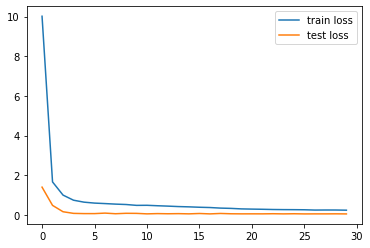

In [23]:
plt.plot(result1.history['loss'], label = 'train loss')
plt.plot(result1.history['val_loss'], label = 'test loss')
plt.legend();

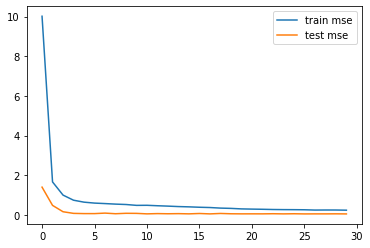

In [24]:
plt.plot(result1.history['mse'], label = 'train mse')
plt.plot(result1.history['val_mse'], label = 'test mse')
plt.legend();

In [25]:
###Let's read back the model and see how well it performs
model_2vars = tf.keras.models.load_model("Location_ANN_2vars/model1_adam_ann.h5")

In [26]:
model_2vars.evaluate(Xval, yval)

71/71 [==============================] - 0s 4ms/step - loss: 0.0584 - mse: 0.0584


[0.05839034169912338, 0.05839034169912338]

In [27]:
Xval.shape

(2241, 2)

In [28]:
yval.shape

(2241, 1)

In [29]:
np.exp(model_2vars.predict(scaled_test_set1['Fold 1']))

array([[223.62451],
       [213.78873],
       [222.46852],
       ...,
       [185.46107],
       [192.97835],
       [176.04668]], dtype=float32)

In [35]:
test_target_dict1['Fold 1'].to_numpy().reshape(-1, 1)

array([[258.03571429],
       [212.03703704],
       [104.33807031],
       ...,
       [186.17021277],
       [272.69910133],
       [874.375     ]])

In [30]:
test_observed = test_target_dict1['Fold 1'].to_numpy().reshape(-1, 1)
test_predicted = np.exp(model_2vars.predict(scaled_test_set1['Fold 1']))
r2 = r2_score(test_observed, test_predicted)
n = test_observed.shape[0]
p = train_set.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
R2_list.append(r2)

print("Fold " + str(1) + " Test R2 score:", np.round(r2, 4))
print("Fold " + str(1) + " Test Adjusted R2 score:", np.round(adjusted_r2, 4))
print()

###Low R2 score with only around 0.1158
###We need to add zipcodes into the data and maybe even remove the latitude and longitude
###Average error that you made. RMSE? Any measure of errors.

Fold 1 Test R2 score: 0.1158
Fold 1 Test Adjusted R2 score: 0.115



## Work with school district data only

In [2]:
##Use february data as experiment
df_FebSD = pd.read_csv('Location_data2/February_2023/February_2023_houses_SD.csv')
df_FebSD

,zpid,SchoolDistrict_aledo isd,SchoolDistrict_allen isd,SchoolDistrict_alvarado isd,SchoolDistrict_alvord isd,SchoolDistrict_anna isd,SchoolDistrict_argyle isd,SchoolDistrict_arlington isd,SchoolDistrict_aubrey isd,SchoolDistrict_azle isd,...,SchoolDistrict_terrell isd,SchoolDistrict_van alstyne isd,SchoolDistrict_venus isd,SchoolDistrict_waxahachie isd,SchoolDistrict_weatherford isd,SchoolDistrict_white settlement isd,SchoolDistrict_wills point isd,SchoolDistrict_wylie isd,SchoolDistrict_other,pricesqft
0,7.894782e+07,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,91.148649
1,2.399566e+08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,108.024691
2,7.893851e+07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,165.413534
3,7.894306e+07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,159.680451
4,2.526456e+08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,206.582633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11199,2.059999e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0.0,1390.625000
11200,3.312331e+08,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0.0,264.900662
11201,2.066871e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,209.279070
11202,9.889846e+07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,221.691678


In [3]:
###We still transform pricesqft into logprice
###Create a function that generates datasets for us first
def prep_data2(splits, df_model):
    data = df_model.to_numpy()
    cv = KFold(n_splits = splits, shuffle = True, random_state = 0)
    cv.split(data)

    train_set_dict = dict()
    train_target_dict = dict()
    scaled_train_target = dict()

    test_set_dict = dict()
    test_target_dict = dict()
    scaled_test_target = dict()

    ###Store K folds data into dictionary
    for i, (train_index, test_index) in enumerate(cv.split(data)):
        train_set = df_model.iloc[train_index].iloc[:, :-1]
        train_target = df_model.iloc[train_index].iloc[:, -1]
        train_set_dict['Fold ' + str(i)] = train_set.copy().to_numpy()
        train_target_dict['Fold ' + str(i)] = train_target.copy().to_numpy().reshape(-1, 1)

        test_set = df_model.iloc[test_index].iloc[:, :-1]
        test_target = df_model.iloc[test_index].iloc[:, -1]
        test_set_dict['Fold ' + str(i)] = test_set.copy().to_numpy()
        test_target_dict['Fold ' + str(i)] = test_target.copy().to_numpy().reshape(-1, 1)
        
        scaled_train_target['Fold ' + str(i)] = np.log(train_target_dict['Fold ' + str(i)])
        scaled_test_target['Fold ' + str(i)] = np.log(test_target_dict['Fold ' + str(i)])
    
    return (train_set_dict, train_target_dict, scaled_train_target,
            test_set_dict, test_target_dict, scaled_test_target)

In [4]:
df_model = df_FebSD.copy().iloc[:, 1:]
splits = 5
all_dicts = prep_data2(splits, df_model)

FebSD_train = all_dicts[0]
FebSD_train_target = all_dicts[1]
FebSD_train_scaled_target = all_dicts[2]

FebSD_test = all_dicts[3]
FebSD_test_target = all_dicts[4]
FebSD_test_scaled_target = all_dicts[5]

In [21]:
###This function is designed to pump out R2 with a different sklearn model
###We need to create R2 for 4 different groups: 0 - 200, 200 - 400, 400 - 600, > 600
###Random Forest will be used as the basic to test how well our model did

range_R2 = [(0,200), (200,400), (400,600), (600,'more')]

##This function will separate the test sets into smaller sets for better calculation
##Return smaller subsets of the Xtest
def create_groups(range_R2, test_set, test_target):
    condition = 0
    indices = 0
    sub_test = dict()
    sub_ytarget = dict()
    for i in range(len(range_R2)):
        min_p = range_R2[i][0]
        max_p = range_R2[i][1]
        
        if max_p != 'more':
            condition = np.logical_and(test_target[:, 0] >= min_p, test_target[:, 0] < max_p)
        else:
            condition = test_target[:, 0] > min_p
        indices =  np.where(condition)[0]
        sub_test[str(min_p) + '_' + str(max_p)] = test_set[indices]
        sub_ytarget[str(min_p) + '_' + str(max_p)] = test_target[indices]
    return sub_test, sub_ytarget
        
###X and y are both dictionary of folds
def K_cv_sklearnml(model, Xtrain, ytrain, Xtest, ytest, n_folds, range_R2):
    m = n_folds
    n = len(range_R2)
    R2_matrix = np.zeros((5,4))
    Adj_R2_matrix = np.zeros((5,4))
    
    for i in range(n_folds):
        train_set = Xtrain['Fold ' + str(i)]
        train_target = ytrain['Fold ' + str(i)]
        test_set = Xtest['Fold ' + str(i)]
        test_target = ytest['Fold ' + str(i)]
        model.fit(train_set, train_target.ravel())
        
        ###Create different observations based on the given data
        ##Generate condition and indices for the numpy array
        sub_test, sub_ytarget = create_groups(range_R2, test_set, test_target)
        
        ##The count helps with filling the R2 of each row
        count = 0
        for group, data in sub_test.items():
            ytarget = sub_ytarget[group]
            ypredict = np.exp(model.predict(data).reshape(-1,1))
            r2 = r2_score(ytarget, ypredict)
            n = data.shape[0]
            p = train_set.shape[1]
            adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
            R2_matrix[i][count] = np.round(r2, 4)
            Adj_R2_matrix[i][count] = np.round(adjusted_r2, 4)
            count += 1
    
    return (R2_matrix, Adj_R2_matrix, sub_test, sub_ytarget)

#### Random Forest

In [25]:
arr = np.array([[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9],
                [10, 11, 12]])

# Select rows that are greater than 3
condition = arr[:, 0] > 3
np.where(condition)[0]

array([1, 2, 3], dtype=int64)

In [23]:
np.where(condition)

(array([1, 2, 3], dtype=int64),)

In [25]:
model = RandomForestRegressor(random_state = 0)
n_folds = 5
Xtrain = FebSD_train
ytrain = FebSD_train_scaled_target
Xtest = FebSD_test
ytest = FebSD_test_target
pack = K_cv_sklearnml(model, Xtrain, ytrain, Xtest, ytest, n_folds, range_R2)

R2_matrix = pack[0]
Adj_R2_matrix = pack[1] 
sub_test = pack[2]
sub_ytarget = pack[3]

In [27]:
sub_test

array([ -1.8245,  -0.5004, -23.4692,  -5.8813])